In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

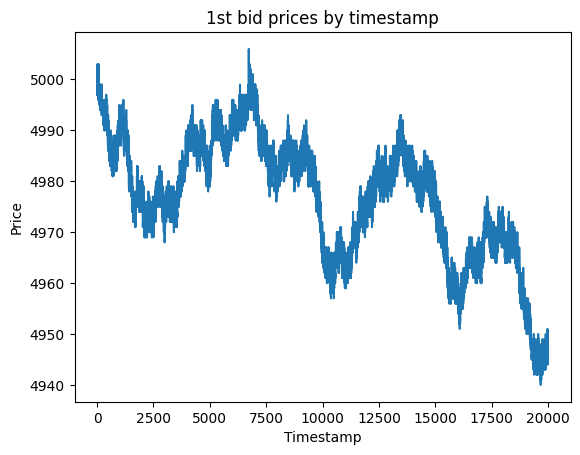

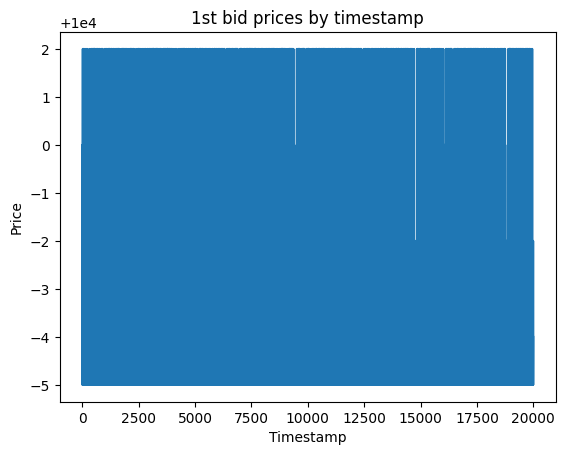

In [39]:
csv_file_path = "./round1_2023.csv"
df = pd.read_csv(csv_file_path, sep=';')

products = np.unique(df['product'])

data = {}

for prod in products:
    data[prod] = df[df['product'] == prod]

for prod in products:
    stat = 'bid_price_1'
    
    plt.title("1st bid prices by timestamp")
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.plot(data[prod][stat])
    plt.show()
    
    # prices = np.unique(data[prod][stat], return_counts=True)
    # 
    # plt.title("Counts of 1st bid prices")
    # plt.xlabel('Price')
    # plt.ylabel('Count')
    # plt.plot(prices[0], prices[1])
    # plt.show()
    # 
    # ############
    # 
    # prices_and_volumes = data[prod][['bid_price_1', 'bid_volume_1']]
    # price_volumes = prices_and_volumes.groupby('bid_price_1').agg({'bid_volume_1': 'sum'})
    # 
    # plt.title("Volumes of 1st bid prices")
    # plt.xlabel('Price')
    # plt.ylabel('Volume')
    # plt.plot(price_volumes)
    # plt.show()
    

In [40]:
data[products[1]].head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
1,-2,0,STARFRUIT,5002,1,4997.0,31.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5002.5,0.00000
3,-2,100,STARFRUIT,4997,24,NaN,NaN,NaN,NaN,5003,2,5004.0,22.0,NaN,NaN,5000.0,0.00000
4,-2,200,STARFRUIT,4997,2,4996.0,20.0,NaN,NaN,5003,20,NaN,NaN,NaN,NaN,5000.0,0.00000
7,-2,300,STARFRUIT,4996,31,NaN,NaN,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,4999.5,-72.00000
9,-2,400,STARFRUIT,4995,27,NaN,NaN,NaN,NaN,5002,27,NaN,NaN,NaN,NaN,4998.5,-52.53125


In [55]:
def get_df(file_path, prod_index):
    df = pd.read_csv(file_path, sep=';')
    products = np.unique(df['product'])
    data = {}
    for product in products:
        data[product] = df[df['product'] == product]
    df_prod1 = pd.DataFrame()
    df_prod1['date'] = data[products[prod_index]]['day'].astype(float)
    df_prod1['time'] = data[products[prod_index]]['timestamp'].astype(float)
    df_prod1['bid'] = data[products[prod_index]]['bid_price_1'].astype(float)
    df_prod1['bs'] = data[products[prod_index]]['bid_volume_1'].astype(float)
    df_prod1['ask'] = data[products[prod_index]]['ask_price_1'].astype(float)
    df_prod1['as'] = data[products[prod_index]]['ask_volume_1'].astype(float)
    df_prod1['mid'] = (df_prod1['bid'] + df_prod1['ask']) / 2
    df_prod1['imb']=df_prod1['bs'].astype(float)/(df_prod1['bs'].astype(float)+df_prod1['as'].astype(float))
    df_prod1['wmid']=df_prod1['ask'].astype(float)*df_prod1['imb']+df_prod1['bid'].astype(float)*(1-df_prod1['imb'])
    return df_prod1

In [57]:
get_df(csv_file_path, 1)

,date,time,bid,bs,ask,as,mid,imb,wmid
1,-2.0,0.0,5002.0,1.0,5003.0,31.0,5002.5,0.031250,5002.031250
3,-2.0,100.0,4997.0,24.0,5003.0,2.0,5000.0,0.923077,5002.538462
4,-2.0,200.0,4997.0,2.0,5003.0,20.0,5000.0,0.090909,4997.545455
7,-2.0,300.0,4996.0,31.0,5003.0,31.0,4999.5,0.500000,4999.500000
9,-2.0,400.0,4995.0,27.0,5002.0,27.0,4998.5,0.500000,4998.500000
...,...,...,...,...,...,...,...,...,...
3990,-2.0,199500.0,4949.0,23.0,4956.0,23.0,4952.5,0.500000,4952.500000
3993,-2.0,199600.0,4949.0,22.0,4956.0,22.0,4952.5,0.500000,4952.500000
3994,-2.0,199700.0,4949.0,27.0,4956.0,27.0,4952.5,0.500000,4952.500000
3996,-2.0,199800.0,4949.0,21.0,4956.0,21.0,4952.5,0.500000,4952.500000
